# Semi-supervised SOMClassifier

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn import metrics

# --- for running the script without pip
import sys
sys.path.append("../")
# ---

import susi

## Get data

We modify the `load_digits` dataset of scikit-learn for this semi-supervised application.
Therefore, we ramdomly set labels of datapoints (only!) in the training dataset to the placeholder -1.
This variable also has to be set in the hyperparameter  `missing_label_placeholder=1` of the `SOMClassifier`.

In [2]:
### define ratios (between 0 and 1)
test_size = 0.5
unlabeled_size = 0.8

# define test dataset
data = load_digits(n_class=5)
X_train, X_test, y_train, y_test = train_test_split(
    data.data, data.target, test_size=test_size, random_state=1)

# preprocessing
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# data with missing labels -> semi-supervised
rng = np.random.RandomState(2)
random_unlabeled_points = rng.rand(len(y_train)) < unlabeled_size
y_train_semi = np.copy(y_train)
y_train_semi[random_unlabeled_points] = -1

print("Datapoints for training with label (supervised):\t", y_train.shape[0])
print("Datapoints for training with label (semi-supervised):\t", np.sum(y_train_semi != -1))
print("Datapoints for testing:\t\t\t\t\t", y_test.shape[0])

Datapoints for training with label (supervised):	 450
Datapoints for training with label (semi-supervised):	 83
Datapoints for testing:					 451


## Supervised Classification SOM on Full Dataset

In [3]:
accuracy_list = []
for random_state in range(30):
    som = susi.SOMClassifier(
        n_rows=15,
        n_columns=15,
        train_mode_unsupervised="online",
        train_mode_supervised="online",
        n_iter_unsupervised=5000,
        n_iter_supervised=5000,
        random_state=random_state)
    som.fit(X_train, y_train)
    y_pred = som.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)
    # print("Accuracy = {0:.2f} %".format(accuracy*100))
print("Accuracy = {0:.1f} % ± {1:.1f}".format(np.mean(accuracy_list)*100, np.std(accuracy_list)*100))

Accuracy = 89.4 % ± 2.6


## Supervised Classification SOM on Semi Dataset

In [4]:
accuracy_s_list = []
for random_state in range(30):
    som_s = susi.SOMClassifier(
        n_rows=15,
        n_columns=15,
        train_mode_unsupervised="online",
        train_mode_supervised="online",
        n_iter_unsupervised=5000,
        n_iter_supervised=5000,
        random_state=random_state)

    # find datapoints with label
    indices = np.where(y_train_semi != -1)[0]

    som_s.fit(X_train[indices], y_train[indices])
    y_pred_s = som_s.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred_s)
    accuracy_s_list.append(accuracy)
    
print("Accuracy = {0:.1f} % ± {1:.1f}".format(np.mean(accuracy_s_list)*100, np.std(accuracy_s_list)*100))

Accuracy = 88.3 % ± 2.8


## Semi-supervised Classification SOM on Semi Dataset

In [5]:
accuracy_semi_list = []
for random_state in range(30):
    som_semi = susi.SOMClassifier(
        n_rows=15,
        n_columns=15,
        train_mode_unsupervised="online",
        train_mode_supervised="online",
        n_iter_unsupervised=5000,
        n_iter_supervised=5000,
        missing_label_placeholder=-1,
        random_state=random_state)
    som_semi.fit(X_train, y_train_semi)
    y_pred_semi = som_semi.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred_semi)
    accuracy_semi_list.append(accuracy)

print("Accuracy = {0:.1f} % ± {1:.1f}".format(np.mean(accuracy_semi_list)*100, np.std(accuracy_semi_list)*100))

Accuracy = 93.2 % ± 1.7


## Plot Accuracies

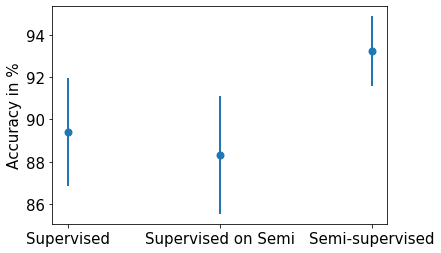

In [6]:
fontsize = 15

accuracy_lists = [accuracy_list, accuracy_s_list, accuracy_semi_list]

plt.errorbar(
    x=[1,2,3],
    y=[np.mean(x)*100 for x in accuracy_lists],
    yerr=[np.std(x)*100 for x in accuracy_lists],
    marker=".",
    mew=5,
    linewidth=0,
    elinewidth=2,)
plt.ylabel("Accuracy in %", fontsize=fontsize)
plt.xticks([1, 2, 3], ["Supervised", "Supervised on Semi", "Semi-supervised"], fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.show()